# ELE 435-535 HW8 Computational LAB

### Name: Adam Chang
### Due Date : 12/7/2018 Friday 11:30 PM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io

%matplotlib inline

## Linear Support Vector Machine

#### Generate artificial gaussian data.

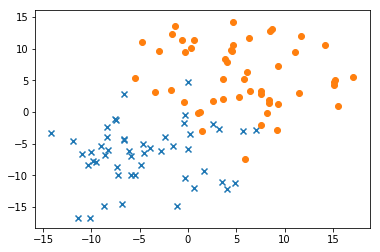

In [2]:
# Generate binary class dataset
center = [5,5]
n_samples = 100
X1 = np.random.normal(0,5,(int(n_samples/2),2)) - center
X2 = np.random.normal(0,5,(int(n_samples/2),2)) + center
X = np.concatenate((X1,X2),0)
Y = np.ones((n_samples,))
Y[:int(n_samples/2)] = -1

plt.figure()
plt.scatter(X1[:,0],X1[:,1],marker='x')
plt.scatter(X2[:,0],X2[:,1],marker='o')
plt.show()

1.Train a support vector machine on the data with $C=1$ and draw a line that separates o and x. Mark each of the support vectors separately and clearly (e.g. by putting a circle around the point).

Note: You can use LinearSVC or SVC from scikit-learn. If you use SVC, be sure to use the linear kernel as follows: SVC(kernel='linear'...).

In [3]:
from sklearn import svm

In [4]:
lsvc = svm.SVC(kernel="linear")
lsvc.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [5]:
def svm_hyperplane_2d(xarr, svc):
    
    # coef[0]x + coef[1]y + intercept = 0
    # y = (-coef[0]x - intercept)/coef[1]
    
    return (-xarr * svc.coef_[0][0] - svc.intercept_)/svc.coef_[0][1]

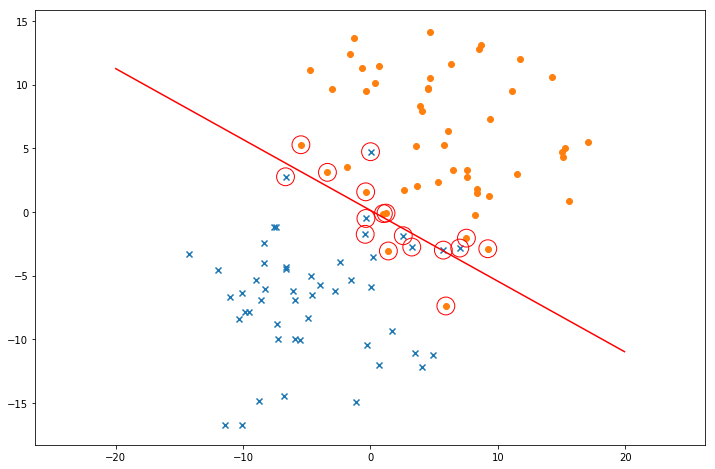

In [6]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.axis("equal")
plt.scatter(X1[:,0],X1[:,1],marker='x')
plt.scatter(X2[:,0],X2[:,1],marker='o')

for i in lsvc.support_:
    circlei = plt.Circle((X[i][0], X[i][1]), .7, color='r', fill=False)
    ax.add_artist(circlei)

plt.plot(np.arange(-20,20,.05), svm_hyperplane_2d(np.arange(-20,20,.05), lsvc), 'r-')

plt.show()

2.Draw a line that separates the data for 8 different $C$ ($10^{-3}$~$10^5$). Also, plot the number of support vectors vs. $C$ (plot x-axis on a log scale). How does the number of support vectors change as $C$ increases and why does it change like that? 

In [7]:
Carr = []
for exp in range(-3,6):
    Carr.append(10**exp)

0.001
0.01
0.1
1
10
100
1000
10000
100000


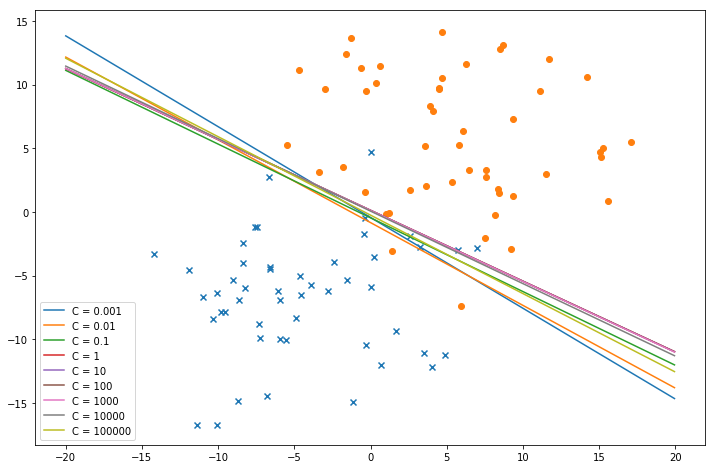

In [8]:
n_support_vec = []

plt.figure(figsize=(12,8))
ax = plt.gca()
plt.scatter(X1[:,0],X1[:,1],marker='x')
plt.scatter(X2[:,0],X2[:,1],marker='o')

for C in Carr:
    print(C)
    lsvc = svm.SVC(kernel="linear", C = C)
    lsvc.fit(X, Y)
    plt.plot(np.arange(-20,20,.05), svm_hyperplane_2d(np.arange(-20,20,.05), lsvc), label="C = " + str(C))
    n_support_vec.append(lsvc.n_support_)
plt.legend()
plt.show()

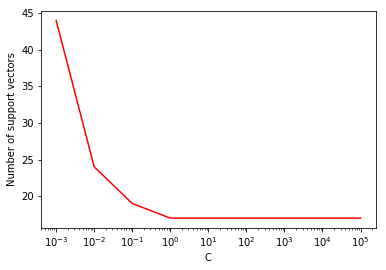

In [9]:
plt.plot(Carr, [sum(x) for x in n_support_vec], 'r-')
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Number of support vectors")
plt.show()

The number of support vectors decreases as $C$ increases, since $C$ is the penalty on (essentially) violation of the margin constraints. A higher penalty results in a hyperplane with narrower margins and thus fewer support vectors.

## Binary Classification

#### Load the YALE database.

X_train: Train data (32256 x 1520) - 40 examples for 38 subjects.

Y_train: Train label (38 subjects (0~37))

X_test: Test data (32256 x 894) - Each subject has different number of test examples.

Y_test: Test label

Train Data: 32256 x 1520
Test Data: 32256 x 894


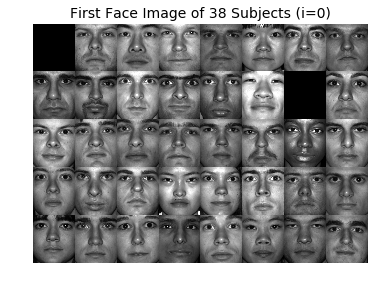

In [10]:
# Load the YALE database
YALE = io.loadmat('YALEBXF.mat') 
X = YALE['X']/255.
Y = YALE['Y']
nr, nc = 192, 168 # height = 192, width = 168
dim = nr * nc     # dimension = 32256
nex = X.shape[1]  # Total number of examples = 2414

nFc = 38          # Total number of faces
nImg = np.zeros(nFc+2) # Numper of examples for each person
for i in range(nFc+2):
    nImg[i] = (Y==i).sum()

ntr = 40
X_train = np.zeros((dim,nFc*ntr))
Y_train = np.zeros(nFc*ntr)
X_test = np.zeros((dim,nex-nFc*ntr))
Y_test = np.zeros(nex-nFc*ntr)

nImg_eff = nImg[np.where(nImg>0)]
nImg_test = nImg_eff - ntr
for i in range(nFc):
    X_train[:,i*ntr:(i+1)*ntr] = X[:,int(np.sum(nImg_eff[:i])):int(np.sum(nImg_eff[:i]))+40]
    Y_train[i*ntr:(i+1)*ntr] = i
    X_test[:,int(np.sum(nImg_test[:i])):int(np.sum(nImg_test[:i+1]))] = X[:,int(np.sum(nImg_eff[:i]))+40:int(np.sum(nImg_eff[:i+1]))]
    Y_test[int(np.sum(nImg_test[:i])):int(np.sum(nImg_test[:i+1]))] = i
    
print('Train Data: %d x %d' %(X_train.shape[0],X_train.shape[1]))
print('Test Data: %d x %d' %(X_test.shape[0],X_test.shape[1]))


def unpackcw(x,nr):
    return x.reshape(-1,nr).T

# Face board of 38 faces
faceIdx = 0 # index of face to display for each subject
Bh, Bw = 5, 8
FB = np.zeros((Bh*nr, Bw*nc))
for i in range(nFc+2):
    if nImg[i]>0:
        loc = np.where(Y==i)[1]
        x = X[:,loc[faceIdx]]
        A = unpackcw(x,nr)
        row, col = divmod(i,Bw)
        rpt, cpt = row*nr, col*nc
        FB[rpt:rpt+nr, cpt:cpt+nc] = A
plt.figure(figsize = (6,6))
plt.imshow(FB, cmap='gray')
plt.axis('off')
plt.title("First Face Image of 38 Subjects (i=%i)" %faceIdx, fontsize=14)
plt.show()

3.Center both the train data and test data using the mean of the train data. Then, project the train data and test data onto the first 128 principal components of the centered train data.

Note: Output should be 128 x N for both the train data and the test data (i.e. lying in the reduced dimension).

In [11]:
mean_X_train = np.mean(X_train, axis=1)
X_train_ctr = X_train - np.tile(mean_X_train, (1520,1)).T
X_test_ctr = X_test - np.tile(mean_X_train, (894,1)).T

In [12]:
np.mean(X_train_ctr, axis=1)

array([-3.97342977e-17, -3.73969861e-17, -5.14208559e-17, ...,
        2.92163954e-19,  5.84327908e-19, -1.16865582e-18])

In [13]:
from sklearn.decomposition import PCA

In [14]:
pca = PCA(n_components = 128)
pca.fit(X_train_ctr.T)
X_train_proj128 = pca.transform(X_train_ctr.T).T
X_test_proj128 = pca.transform(X_test_ctr.T).T

4.Train the binary classifier using support vector machine to classify subject 0 and subject 1. Use the projected data. Plot accuracy vs. $C$ for $C=10^{-5}$~$10^{5}$ (plot x-axis on a log scale). 

In [15]:
faces_e1_indices = np.concatenate([np.where(Y_train == 0)[0], np.where(Y_train == 1)[0]])
print(faces_e1_indices)
faces_e1_y = Y_train[faces_e1_indices]
print(faces_e1_y)
faces_e1_x = X_train_proj128.T[faces_e1_indices]
print(faces_e1_x.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
(80, 128)


In [16]:
faces_e1_indices_test = np.concatenate([np.where(Y_test == 0)[0], np.where(Y_test == 1)[0]])
print(faces_e1_indices_test)
faces_e1_y_test = Y_test[faces_e1_indices_test]
print(faces_e1_y_test)
faces_e1_x_test = X_test_proj128.T[faces_e1_indices_test]
print(faces_e1_x_test.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(48, 128)


In [17]:
Carr_faces = []
for exp in range(-5,6):
    Carr_faces.append(10**exp)

In [18]:
e1_accuracies = []

for C in Carr_faces:
    faces_e1_svc = svm.SVC(kernel="linear", C = C)
    faces_e1_svc.fit(faces_e1_x, faces_e1_y)
    
    e1_accuracies.append(faces_e1_svc.score(faces_e1_x_test, faces_e1_y_test))

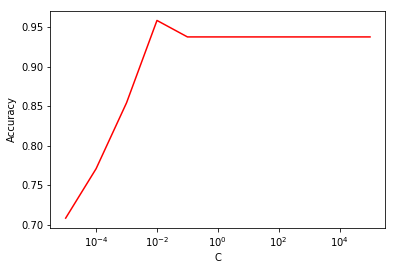

In [19]:
plt.plot(Carr_faces, e1_accuracies, 'r-')
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.show()

5.Repeat 4 with subject 2 and subject 25.

In [20]:
faces_e2_indices = np.concatenate([np.where(Y_train == 2)[0], np.where(Y_train == 25)[0]])
print(faces_e2_indices)
faces_e2_y = Y_train[faces_e2_indices]
print(faces_e2_y)
faces_e2_x = X_train_proj128.T[faces_e2_indices]
print(faces_e2_x.shape)

[  80   81   82   83   84   85   86   87   88   89   90   91   92   93
   94   95   96   97   98   99  100  101  102  103  104  105  106  107
  108  109  110  111  112  113  114  115  116  117  118  119 1000 1001
 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015
 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029
 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039]
[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.
 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.
 25. 25. 25. 25. 25. 25. 25. 25.]
(80, 128)


In [21]:
faces_e2_indices_test = np.concatenate([np.where(Y_test == 2)[0], np.where(Y_test == 25)[0]])
print(faces_e2_indices_test)
faces_e2_y_test = Y_test[faces_e2_indices_test]
print(faces_e2_y_test)
faces_e2_x_test = X_test_proj128.T[faces_e2_indices_test]
print(faces_e2_x_test.shape)

[ 48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605]
[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.
 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.]
(48, 128)


In [22]:
e2_accuracies = []

for C in Carr_faces:
    faces_e2_svc = svm.SVC(kernel="linear", C = C)
    faces_e2_svc.fit(faces_e2_x, faces_e2_y)
    
    e2_accuracies.append(faces_e2_svc.score(faces_e2_x_test, faces_e2_y_test))

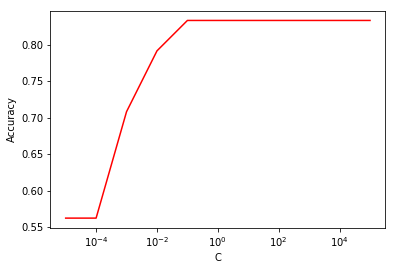

In [23]:
plt.plot(Carr_faces, e2_accuracies, 'r-')
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.show()

## Multi-class Classification

Now, we will use the support vector machine to carry out multi-class classification.

6.Standardize (centering and transforming to have unit variance for all features) the train data and test data. Use the data projected to the top 128 principal components from the previous question.

Note: Use sklearn.preprocessing.StandardScaler for the standardization step.

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
sscaler = StandardScaler()
sscaler.fit(X_train_proj128.T)
X_train_sscale = sscaler.transform(X_train_proj128.T)

X_test_sscale = sscaler.transform(X_test_proj128.T)

In [26]:
X_test_sscale.shape

(894, 128)

7.Train one-vs-rest classifier on the train data to classify subjects 0~37. Use a support vector machine with $C=0.01$. Plot a bar graph of each subject's accuracy. What is the overall accuracy of the classifier?

Note: Use sklearn.multiclass.OneVsRestClassifier which allows you to convert any appropriate estimation function into a multi-class classifier.

In [27]:
from sklearn.multiclass import OneVsRestClassifier

In [28]:
mc_svc = svm.SVC(kernel="linear", C=0.01)
ovr = OneVsRestClassifier(mc_svc)

In [29]:
ovr.fit(X_train_sscale, Y_train)

OneVsRestClassifier(estimator=SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          n_jobs=None)

In [30]:
mc_subj_accuracy = []

for subj in range(nFc):
    tstindices = np.where(Y_test == subj)[0]
    mc_subj_accuracy.append(ovr.score(X_test_sscale[tstindices], Y_test[tstindices]))

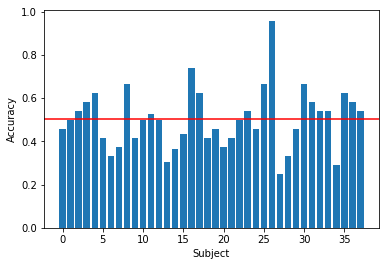

In [31]:
plt.bar(range(nFc), mc_subj_accuracy)
plt.axhline(ovr.score(X_test_sscale, Y_test), color='r')
plt.xlabel("Subject")
plt.ylabel("Accuracy")
plt.show()

In [32]:
## overall accuracy
ovr.score(X_test_sscale, Y_test)

0.5033557046979866